In [ ]:
#imports
import pandas as pd
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Let's us read the input data
#df = pd.read_csv('/content/drive/MyDrive/AI4GOVMASTER/googlecolab/Irelandconst.csv')
df = pd.read_csv('/content/drive/MyDrive/AI4GOVMASTER/googlecolab/Colab Notebooks/contratos.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/AI4gov_CPV/data_cpv/data-be-2020.csv', sep=";")
#df = pd.read_csv('/content/drive/MyDrive/AI4GOV-Cohort2/AI4gov_CPV/data_cpv/divisions.csv')
df


,id,title,cpvs
0,6487.0,Suministro de Agua Mineral Natural para la Exc...,15981000
1,133450.0,Plan de transparencia y dinamización del plan ...,72000000
2,83275.0,Asistencia del servicio técnico de montaña par...,63514000
3,18991.0,Instalación de marquesina metálica en Penyeta ...,45213315
4,95544.0,Contratación de una agencia de comunicación qu...,79341400
...,...,...,...
5988,5390555.0,La recogida de contenedores de plástico sitos ...,90500000
5989,3858930.0,"las obras de ""proyecto básico y de ejecución r...","45261213,45"
5990,4385519.0,Servicio de tratamiento y eliminación de resid...,90513000
5991,1873653.0,Una asistencia técnica par la dirección facult...,71200000


In [21]:
# Remove identificador and Tipo de contrato, which are not needed
# This is a little of data cleaning, but 'Tipo de contrato' (type of contract)
# could be used as an additional feature.
df = df.drop(['id'], axis = 1)
df.head()

,title,cpvs
0,Suministro de Agua Mineral Natural para la Exc...,15981000
1,Plan de transparencia y dinamización del plan ...,72000000
2,Asistencia del servicio técnico de montaña par...,63514000
3,Instalación de marquesina metálica en Penyeta ...,45213315
4,Contratación de una agencia de comunicación qu...,79341400


In [22]:
# Let us explore the size of the data
df.count()

title    5993
cpvs     5108
dtype: int64

In [29]:
# All the data is clean. How many classes of CPV do we have in this dataset?
df.groupby(['cpvs']).count()


,title
cpvs,
"09122110,09211000,30163100,09132100,09122210,09134000",1
"09130000,09132100,09133000,09134200",1
"09134000,09134100,09134200",1
14221000,3
14310000,1
...,...
98300000,3
98312000,1
98392000,1


In [28]:
# Data is unbalanced! Let's try first a binary classifier for the category with
# most samples
df.groupby(['cpvs']).count().max()

title    222
dtype: int64

In [31]:
# To print the category too:
series = df.groupby(['cpvs']).count().sort_values(by='title', ascending=False)
series

,title
cpvs,
72267100,222
50110000,199
79632000,180
79341400,129
80500000,109
...,...
39800000,1
39811200,1
"39830000,18424300,19520000,19640000,24452000,24455000,39220000,39224000,39224300,39525800,39821000,39831210,39831220,39831500,39832000,39833000",1


In [32]:
# Looking it in the table above, this corresponds to CPV 45000000,
# which is grouping construction work, site preparation work, etc.
# So we will turn all other CPVs into 'OTHER'
for ind, row in df.iterrows():
    if row['cpvs']!="72267100":
    #if row['CPV']!=79000000:
        df.at[ind,'cpvs'] = 0
df

,title,cpvs
0,Suministro de Agua Mineral Natural para la Exc...,0
1,Plan de transparencia y dinamización del plan ...,0
2,Asistencia del servicio técnico de montaña par...,0
3,Instalación de marquesina metálica en Penyeta ...,0
4,Contratación de una agencia de comunicación qu...,0
...,...,...
5988,La recogida de contenedores de plástico sitos ...,0
5989,"las obras de ""proyecto básico y de ejecución r...",0
5990,Servicio de tratamiento y eliminación de resid...,0
5991,Una asistencia técnica par la dirección facult...,0


In [33]:
X = df['title'].astype('string')
X

0       Suministro de Agua Mineral Natural para la Exc...
1       Plan de transparencia y dinamización del plan ...
2       Asistencia del servicio técnico de montaña par...
3       Instalación de marquesina metálica en Penyeta ...
4       Contratación de una agencia de comunicación qu...
                              ...                        
5988    La recogida de contenedores de plástico sitos ...
5989    las obras de "proyecto básico y de ejecución r...
5990    Servicio de tratamiento y eliminación de resid...
5991    Una asistencia técnica par la dirección facult...
5992                   Mantenimiento maquinaria por Eypar
Name: title, Length: 5993, dtype: string

In [34]:
Y = df['cpvs'].astype('string')
Y

0       0
1       0
2       0
3       0
4       0
       ..
5988    0
5989    0
5990    0
5991    0
5992    0
Name: cpvs, Length: 5993, dtype: string

In [35]:
df.dropna()
df.groupby(['cpvs']).count()

,title
cpvs,
0,5771
72267100,222


In [36]:
# We apply an undersampler classifier in order to balance data.
# The undersampler will take elements from the majority class
# In this case, the majority class is "Other", so we are not
# removing any annotated labels.
# We have to be careful with random undersampling if there are
# categories with very little data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                    tokenizer=word_tokenize,
                                    max_features=None,
                                    lowercase=True)),
    ('undersample', RandomUnderSampler(sampling_strategy='majority')),
    ('linearsvc', LinearSVC(random_state=42))
])
clf.fit(X_train, y_train)
print(f' clf fit done')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


 clf fit done


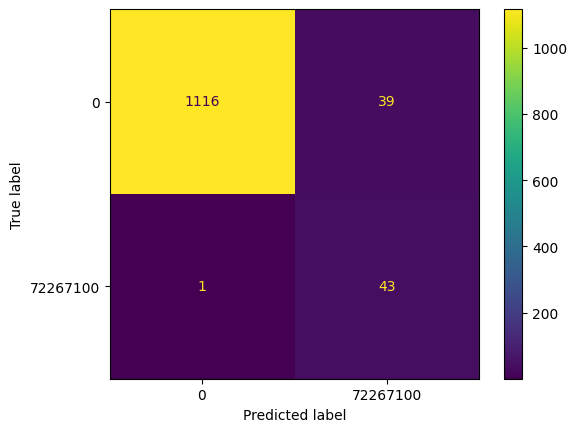

In [37]:
#plot_confusion_matrix(clf, X_test, y_test)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

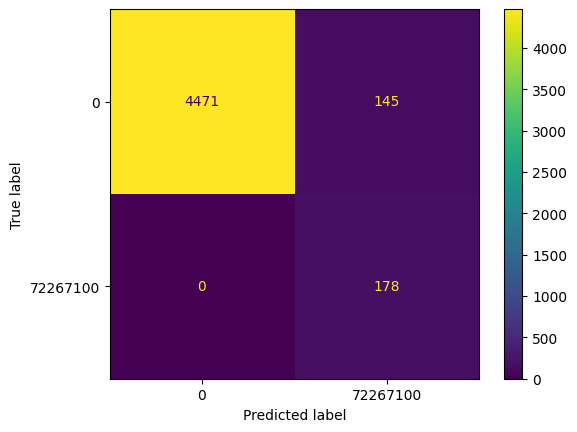

In [38]:
# Let's plot the training error
predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [39]:
# Now let's see the evaluation results
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1155
    72267100       0.52      0.98      0.68        44

    accuracy                           0.97      1199
   macro avg       0.76      0.97      0.83      1199
weighted avg       0.98      0.97      0.97      1199



In [40]:
# printing training error results
y_pred = clf.predict(X_train)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4616
    72267100       0.55      1.00      0.71       178

    accuracy                           0.97      4794
   macro avg       0.78      0.98      0.85      4794
weighted avg       0.98      0.97      0.97      4794



In [45]:
# Not bad; not perfect results.
# Why are there only 3917 in support if we had almost 20k?

# Ok, now let's see our classifier in practice:
test = clf.predict(["Reparación Escalón lateral tras colisión del vehículo BFP matrícula 0037LCL Forestal Cabanes",
    "Plan de transparencia y dinamización del plan de modernización administrativa de loa Ayuntamientos con la herramienta gestiona",
    "Servicio de recepción, apertura y cierre de puertas y ventanas",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación",
                   "Materiales de oficina",
                   "Grúas para demolición",
                   "Gruas para demolicion",
                   "Me comí un sandwich ayer",
                   "Aplicación informática de instalación de puertas"])
test

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], dtype=object)